# Churn Analysis

### Import required libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
#Each pyplot function makes some change to a figure: e.g., creates a figure, 
# creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.cm as cm #indicates the colormap and the norm to be used

#add plots inside jupyter notebook
%matplotlib inline 

In order to preprocess and perform feature engineering, we need the `LabelEncoder` from `scikit-learn` module.

In [3]:
from sklearn.preprocessing import LabelEncoder

And last, we import the libraries for splitting the set, finding the best model and evaluating the final models.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

In [8]:
from sklearn.feature_selection import SelectFromModel

### Load and review the data

In [9]:
df = pd.read_csv('Churn_Modelling.csv')

In [10]:
print(f"The dataset contains {df.shape[0]} observations, from which we have {df.shape[1]} attributes")

The dataset contains 10000 observations, from which we have 14 attributes


In [11]:
print(f"Among their attributes, we observe {df.columns.tolist()}")

Among their attributes, we observe ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


Check missing values

In [12]:
print("Column          Missing values")
print("------------------------------")
df.isnull().sum()

Column          Missing values
------------------------------


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Check data type of each column

In [13]:
print("Column               types")
print("--------------------------")
df.dtypes

Column               types
--------------------------


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

We can see that the dataset contains both categorical and continuous variables.

How many unique values do we have for each attribute?

In [14]:
print("Column         Unique Values")
print("----------------------------")
df.nunique()

Column         Unique Values
----------------------------


RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [15]:
print(f"Our target variable is Exited. We can observe that it has only two possible variables: {df['Exited'].unique().tolist()}")

Our target variable is Exited. We can observe that it has only two possible variables: [1, 0]


### Clean the data

From the name of the attributes, we can distinguish that three columns are spectific for identifying each customer. We need to drop them from the dataset as they are not going to be useful for the analysis.

In [16]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

We also can rename ethe columns to avoid having Capital letters.

In [17]:
new_names = {
    'CreditScore': 'credit_score',
    'Geography': 'country',
    'Gender': 'gender',
    'Age': 'age',
    'Tenure': 'tenure',
    'Balance': 'balance',
    'NumOfProducts': 'number_products',
    'HasCrCard': 'owns_credit_card',
    'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary',
    'Exited': 'exited'
}

In [18]:
df.rename(columns=new_names, inplace=True)

In [19]:
df.head()

,credit_score,country,gender,age,tenure,balance,number_products,owns_credit_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


---

## Exploratory Data Analysis

Because our target variable is `exited`, we should analyse the data focusing on how the different features are related to this variable. Let's start by getting how many customers have been lost.

In [20]:
amount_retained = df[df['exited'] == 0]['exited'].count() / df.shape[0] * 100
amount_lost = df[df['exited'] == 1]['exited'].count() / df.shape[0] * 100

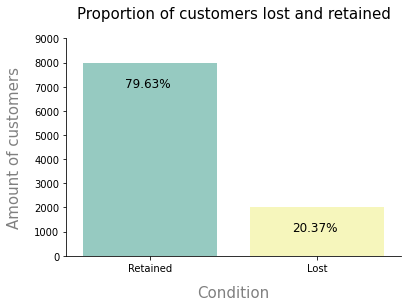

In [21]:
fig, ax = plt.subplots()
sns.countplot(x='exited', palette="Set3", data=df)
plt.xticks([0, 1], ['Retained', 'Lost'])
plt.xlabel('Condition', size=15, labelpad=12, color='grey')
plt.ylabel('Amount of customers', size=15, labelpad=12, color='grey')
plt.title("Proportion of customers lost and retained", size=15, pad=20)
plt.ylim(0, 9000)
plt.text(-0.15, 7000, f"{round(amount_retained, 2)}%", fontsize=12)
plt.text(0.85, 1000, f"{round(amount_lost, 2)}%", fontsize=12)
sns.despine()
plt.show()

We can observe that **20.37%** of the customers have churned. 

This information is valuable because for classification models we need to confirm that our dataset does not suffer from data imbalance, which usually reflects an unequal distribution of classes within a dataset. Even though the class is not equally distributed, we can say that it does not suffer from high-class imbalance.

After that, we will analyse the relationship between categorical variables and the target variable.

In [22]:
categorical_labels = [['gender', 'country'], ['owns_credit_card', 'is_active_member']]
colors = [['Set1', 'Set2'], ['Set3', 'PuRd']]

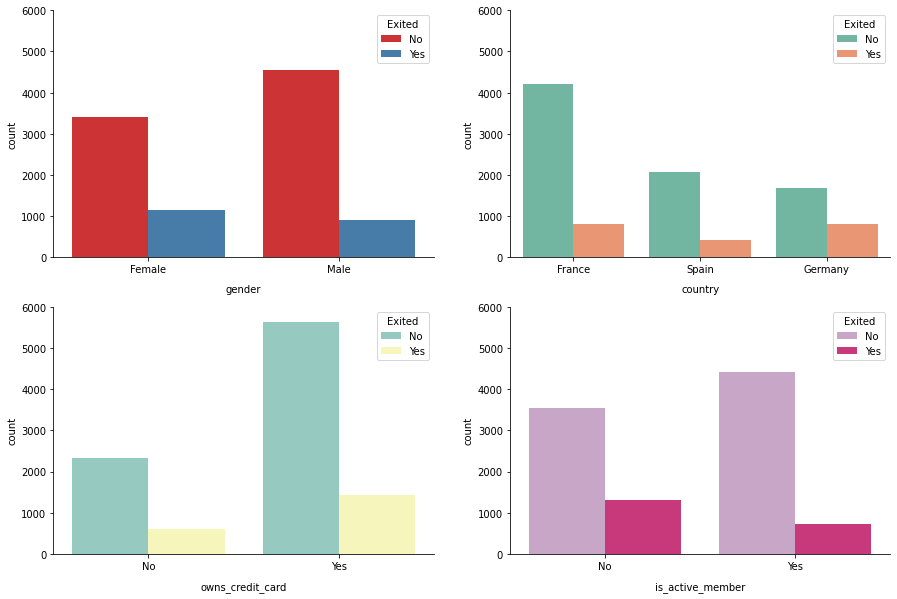

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for i in range(2):
    for j in range(2):
        feature = categorical_labels[i][j]
        color = colors[i][j]
        ax1 = sns.countplot(x=feature, hue='exited', palette=color, data=df, ax=ax[i][j])
        ax1.set_xlabel(feature, labelpad=10)
        ax1.set_ylim(0, 6000)
        ax1.legend(title='Exited', labels= ['No', 'Yes'])
        if i == 1:
            ax1.set_xticklabels(['No', 'Yes'])
sns.despine()

In [24]:
female_churn = round(df[(df['exited'] == 1) & (df['gender'] == 'Female')]['exited'].count() / df[df['gender'] == 'Female']['exited'].count()*100, 2)
male_churn = round(df[(df['exited'] == 1) & (df['gender'] == 'Male')]['exited'].count() / df[df['gender'] == 'Male']['exited'].count() * 100, 2)

print(f"The percentage of female customers churning is {female_churn}% while the percetage of male customers churning is {male_churn}%")

The percentage of female customers churning is 25.07% while the percetage of male customers churning is 16.46%


In [25]:
active_churn = round(df[(df['exited'] == 1) & (df['is_active_member'] == 1)]['exited'].count() / df[df['is_active_member'] == 1]['exited'].count()*100, 2)
inactive_churn = round(df[(df['exited'] == 1) & (df['is_active_member'] == 0)]['exited'].count() / df[df['is_active_member'] == 0]['exited'].count() * 100, 2)

print(f"The percentage of active members churning is {active_churn}% while the percetage of inactive members churning is {inactive_churn}%")

The percentage of active members churning is 14.27% while the percetage of inactive members churning is 26.85%


In [26]:
credit_churn = round(df[(df['exited'] == 1) & (df['owns_credit_card'] == 1)]['exited'].count() / df[df['owns_credit_card'] == 1]['exited'].count()*100, 2)
no_credit_churn = round(df[(df['exited'] == 1) & (df['owns_credit_card'] == 0)]['exited'].count() / df[df['owns_credit_card'] == 0]['exited'].count() * 100, 2)

print(f"The percentage of custumers with credit card churning is {credit_churn}% while the percetage that do not have credit cards and")
print(f"churn is {no_credit_churn}%")

The percentage of custumers with credit card churning is 20.18% while the percetage that do not have credit cards and
churn is 20.81%


From the plots and the calculations, we learn several things:

- The proportion of female customers that churn is greater than the proportion of male customers. 

- Most of the customers come from France. Nevertheless, Germany and Spain have a greater proportion of customers churning.

- The proportion of inactive members that churn is higher than the proportion of active members.

Now, we will focus on the relationship between continuous variables and the target variable.

In [27]:
numerical_labels = [['age', 'credit_score'], 
                    ['tenure', 'balance'],
                   ['number_products', 'estimated_salary']]
num_colors = [['Set1', 'Set2'], 
              ['Set3', 'PuRd'],
              ['Spectral', 'Wistia']]

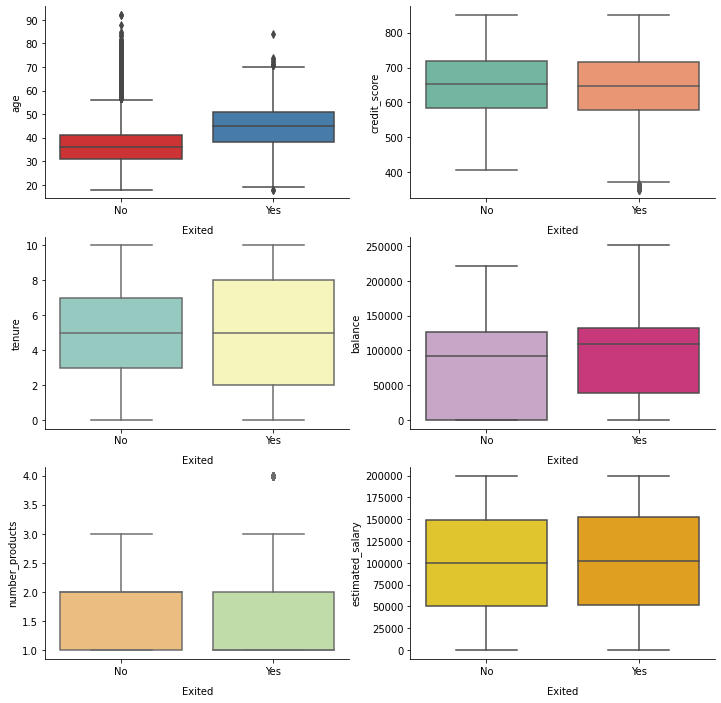

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    for j in range(2):
        feature = numerical_labels[i][j]
        color = num_colors[i][j]
        ax1 = sns.boxplot(x='exited', y=feature, palette=color, data=df, ax=ax[i][j])
        ax1.set_xlabel('Exited', labelpad=10)
        ax1.set_xticklabels(['No', 'Yes'])
sns.despine()

In [29]:
# Check median age for churning and no churning customers
pd.DataFrame(df.groupby('exited')['age'].describe())

,count,mean,std,min,25%,50%,75%,max
exited,,,,,,,,
0,7963.0,37.408389,10.125363,18.0,31.0,36.0,41.0,92.0
1,2037.0,44.837997,9.761562,18.0,38.0,45.0,51.0,84.0


In [30]:
# Check median age for churning and no churning customers
pd.DataFrame(df.groupby('exited')['balance'].describe())

,count,mean,std,min,25%,50%,75%,max
exited,,,,,,,,
0,7963.0,72745.296779,62848.040701,0.0,0.00,92072.68,126410.28,221532.80
1,2037.0,91108.539337,58360.794816,0.0,38340.02,109349.29,131433.33,250898.09


From the plots and the calculations, we learn several things:

- Customers that churn are older than those who are retained.

- There is no difference in the median credit score or tenure between lost and retained customers.

- Among the customers that churn, most of them seem to still have a significant balance in their bank account.

- Neither estimated salary nor the number of products seems to have an effect on customer churn.

Last, we can examine the correlation between the different continuos variables to discover if there is any codependency between them.

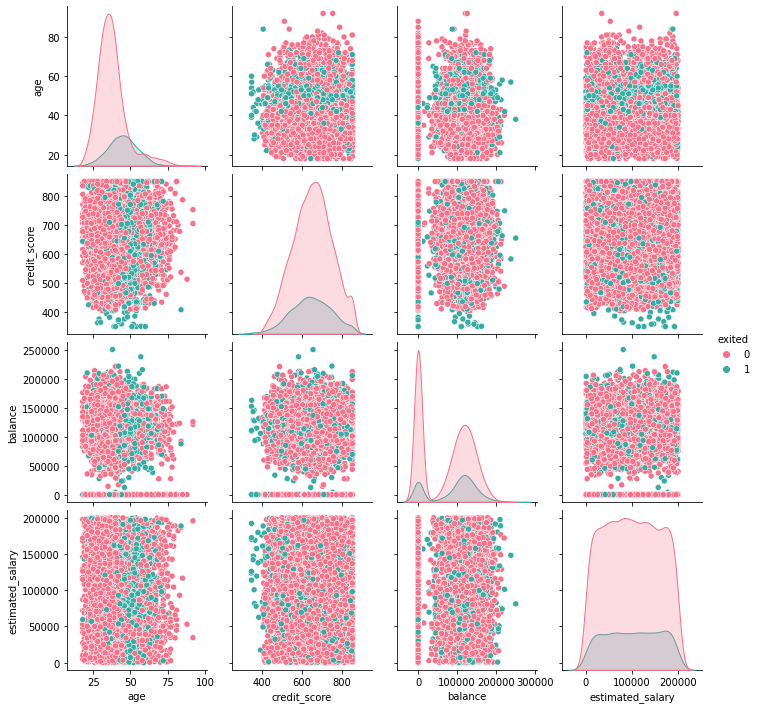

In [31]:
sns.pairplot(df, vars=['age', 'credit_score', 'balance', 'estimated_salary'], 
             hue="exited", palette='husl')
sns.despine()

No relationship can be inferred between continuous variables from the plots.

---

## Feature Engineering

Before we dive into finding a model to predict customer churn, we need to do some feature engineering. First, we'll create new features. After that, we'll encode categorical variables.

### New Variable Creation

Some of the variables that we have, can be combined in new features that describe better the customers. 

We saw before that credit score had no effect on churning because credit score frequently increases with time (and consequently, with age), we'll create a new feature to account for credit score behavior by age 

In [32]:
df['creditscore_age_ratio'] = df['credit_score'] / df['age']

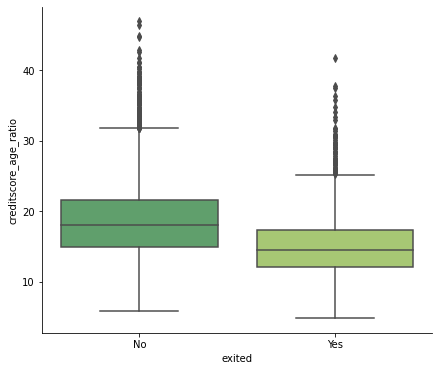

In [33]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(y='creditscore_age_ratio', x='exited', palette='summer', data=df)
ax.set_xticklabels(['No', 'Yes'])
sns.despine()

The customers who are churning appear to have a smaller credit score by age ratio.

We have seen that the estimated salary has no effect on the likelihood of a customer churning. However, a feature that could be interesting to explore is the ratio between balance and the salary because this can be an estimation of which percentage of their salary a customer spend , and could be a probable indicator of churning. 

In [34]:
df['balance_salary_ratio'] = df['balance'] / df['estimated_salary']

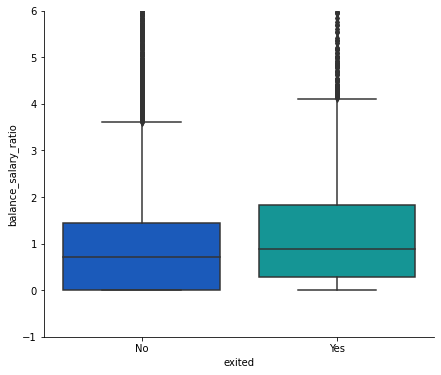

In [35]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(y='balance_salary_ratio', x='exited', palette='winter', data=df)
ax.set_xticklabels(['No', 'Yes'])
ax.set_ylim(-1, 6)
sns.despine()

From the plot, we can learn that customers with a higher balance salary ratio churn more than those with a lower ratio.

### Encoding Categorical Variables

First we are going to select all the independant variables that we are going to use to predict the class of a customer.

In [36]:
x_drop = ['exited', 'estimated_salary', 'balance', 'age', 'credit_score']

In [37]:
x = df.drop(x_drop, axis=1)
y = df['exited']

Because the model require numerical values, we need to encode those categorical values that are strings (`gender` and `country`) into numerical values. For that aim, we'll use the `LabelEncoder` from `scikit-learn`.

In [38]:
for label in ['gender', 'country']:
    le = LabelEncoder()
    le.fit(x[label])
    print(le.classes_)
    x.loc[:, label] = le.transform(x[label])

['Female' 'Male']
['France' 'Germany' 'Spain']


In [39]:
x['gender'].unique()

array([0, 1])

In [40]:
x['country'].unique()

array([0, 2, 1])

In [41]:
features = x.columns

In [42]:
x = np.array(x)
y = np.array(y)

### Split the data

In order to train and test our model, we need to split our dataset into to subdatasets, the training and the test dataset.

It is common to use the rule of 80%-20% to split the original dataset. It is important to use a reliable method to split the dataset to avoid data leakage; this is the presence in the test set of examples that were also in the training set and can cause overfitting. 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, 
                                                    shuffle=True, stratify=y)

---

## Model fitting

We are ready to build different models looking for the best fit. Predicting customer churn is a **binary classification problem**: Customers are either lost or retained in a given period of time.

For this aim, we'll test: 

1. [Logistic regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
2. [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) with Radial basis function kernel
3. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

Let's create two functions that will help getting the results easier.

In [44]:
def print_best_model(model):
    """
    Prints the best parameteres, score and estimator for the model given.
    """
    print(f"The best parameters are: {model.best_params_}")
    print(f"The best model score is: {model.best_score_}")    
    print(f"The best estimator is: {model.best_estimator_}")

In [45]:
def get_scores(y, predicted, predicted_proba):
    """
    returns the roc auc scores for the given predictions
    """
    auc_score = roc_auc_score(y, predicted)
    fpr_df, tpr_df, _ = roc_curve(y, predicted_proba) 
    return auc_score, fpr_df, tpr_df

In [46]:
def get_confusion_matrix(y_test, y_predicted):
    plt.figure()
    random_confusion = confusion_matrix(y_test, y_predicted)
    ax = sns.heatmap(random_confusion, annot=True, cmap="YlGnBu");
    ax.set_ylim([0,2]);

### 1. Parameter Searching

We will determine the parameters and values that we want to search in each of our models. Then, we will perform the `GridSearchCV` and set the best parameters obtained in our model.

#### Logistic Regression

In [47]:
param_grid_log = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'max_iter': [200, 300],
    'penalty': ['l2'],
    'tol':[0.00001, 0.0001],
}

In [48]:
log_first = LogisticRegression(solver='lbfgs')

In [49]:
log_grid = GridSearchCV(log_first, param_grid=param_grid_log, cv=10, verbose=1, n_jobs=-2)

In [50]:
log_grid.fit(x, y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed:   19.4s finished


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-2,
             param_grid={'C': [0.1, 1, 10, 50, 100, 200],
                         'max_iter': [200, 300], 'penalty': ['l2'],
                         'tol': [1e-05, 0.0001]},
             verbose=1)

In [51]:
print_best_model(log_grid)

The best parameters are: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'tol': 1e-05}
The best model score is: 0.8117999999999999
The best estimator is: LogisticRegression(C=100, max_iter=200, tol=1e-05)


#### Support Vector Machine

In [52]:
param_grid_svm = {
    'C': [0.5, 100, 150],
    'kernel': ['rbf'],
    'gamma': [0.1, 0.01, 0.001],
    'probability': [True]
}

In [53]:
svm_first = SVC()

In [54]:
svm_grid = GridSearchCV(svm_first, param_grid=param_grid_svm, cv=3, verbose=3, n_jobs=-2)

In [55]:
svm_grid.fit(x, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:  5.2min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-2,
             param_grid={'C': [0.5, 100, 150], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf'], 'probability': [True]},
             verbose=3)

In [56]:
print_best_model(svm_grid)

The best parameters are: {'C': 150, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
The best model score is: 0.8342996867173221
The best estimator is: SVC(C=150, gamma=0.01, probability=True)


#### Random Forest Classifier

In [57]:
param_grid = {'max_depth': [3, 5, 6], 
              'max_features': [2, 4, 6],
              'n_estimators':[50, 100],
              'min_samples_split': [3, 5, 7]}

In [58]:
random_forest = RandomForestClassifier()

In [59]:
random_forest_grid = GridSearchCV(random_forest, param_grid, cv=5, refit=True, verbose=3, n_jobs=-2)

In [60]:
random_forest_grid.fit(x, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-2)]: Done 270 out of 270 | elapsed:  1.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [3, 5, 6], 'max_features': [2, 4, 6],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [50, 100]},
             verbose=3)

In [61]:
print_best_model(random_forest_grid)

The best parameters are: {'max_depth': 6, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 100}
The best model score is: 0.8440000000000001
The best estimator is: RandomForestClassifier(max_depth=6, max_features=4, min_samples_split=3)


### 2. Fitting Best Models

Now, we have the best models and we can train them using the training dataset and test their performance using the testing set.

#### Logistic Regression

In [62]:
best_log_estimator = LogisticRegression(C=100, max_iter=200, penalty='l2', tol=1e-05, solver='lbfgs')

In [63]:
best_log_estimator.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=200, tol=1e-05)

#### Support Vector Machine

In [64]:
best_svm_estimator = SVC(C=100, gamma=0.01, kernel='rbf', probability=True)

In [65]:
best_svm_estimator.fit(X_train, y_train)

SVC(C=100, gamma=0.01, probability=True)

### Random Forest Classifier

In [66]:
best_rf_estimator = RandomForestClassifier(max_depth=6, max_features=6, min_samples_split=3, n_estimators=100)

In [67]:
best_rf_estimator.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=6, min_samples_split=3)

### 3. Metrics of Best Models

After training the best models with our training dataset, we are going to see how well they perform using our test set.

#### Logistic Regression

In [68]:
log_predict_train = best_log_estimator.predict(X_train)

In [69]:
log_predict_test = best_log_estimator.predict(X_test)

In [70]:
accuracy_score(y_train, log_predict_train)

0.81475

In [71]:
print(classification_report(y_train, log_predict_train))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      6370
           1       0.71      0.15      0.25      1630

    accuracy                           0.81      8000
   macro avg       0.77      0.57      0.57      8000
weighted avg       0.80      0.81      0.76      8000



In [72]:
accuracy_score(y_test, log_predict_test)

0.807

In [73]:
print(classification_report(y_test, log_predict_test))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1593
           1       0.64      0.12      0.20       407

    accuracy                           0.81      2000
   macro avg       0.73      0.55      0.54      2000
weighted avg       0.78      0.81      0.75      2000



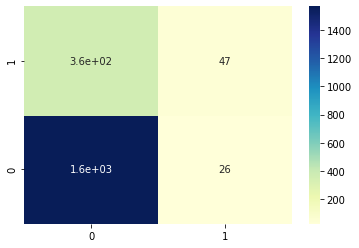

In [74]:
get_confusion_matrix(y_test, log_predict_test)

#### Support Vector Machine

a. **Radial Kernel**

In [75]:
svm_predict_train = best_svm_estimator.predict(X_train)

In [76]:
svm_predict_test = best_svm_estimator.predict(X_test)

In [77]:
accuracy_score(y_train, svm_predict_train)

0.846

In [78]:
print(classification_report(y_train, svm_predict_train))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      6370
           1       0.80      0.33      0.47      1630

    accuracy                           0.85      8000
   macro avg       0.82      0.65      0.69      8000
weighted avg       0.84      0.85      0.82      8000



In [79]:
accuracy_score(y_test, svm_predict_test)

0.8345

In [80]:
print(classification_report(y_test, svm_predict_test))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1593
           1       0.72      0.31      0.43       407

    accuracy                           0.83      2000
   macro avg       0.78      0.64      0.67      2000
weighted avg       0.82      0.83      0.81      2000



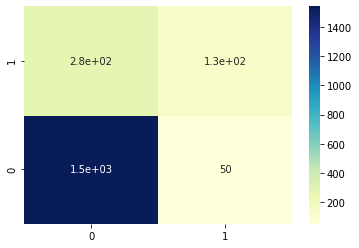

In [81]:
get_confusion_matrix(y_test, svm_predict_test)

#### Random Forest Classifier

In [82]:
rf_predict_train = best_rf_estimator.predict(X_train)

In [83]:
rf_predict_test = best_rf_estimator.predict(X_test)

In [84]:
accuracy_score(y_train, rf_predict_train)

0.850375

In [85]:
print(classification_report(y_train, rf_predict_train))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      6370
           1       0.77      0.38      0.51      1630

    accuracy                           0.85      8000
   macro avg       0.81      0.68      0.71      8000
weighted avg       0.84      0.85      0.83      8000



In [86]:
accuracy_score(y_test, rf_predict_test)

0.843

In [87]:
print(classification_report(y_test, rf_predict_test))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.73      0.36      0.49       407

    accuracy                           0.84      2000
   macro avg       0.79      0.66      0.70      2000
weighted avg       0.83      0.84      0.82      2000



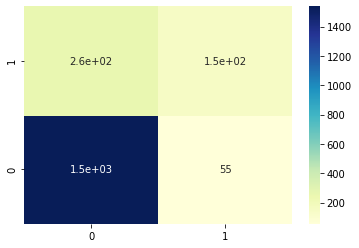

In [88]:
get_confusion_matrix(y_test, rf_predict_test)

#### Comparison of ROC Curves for the three models

We can further investigate the False positive rates and true positive rates using ROC Curve and calculating the area under the curve that it is also a metric of the prediction power of our model (if the value is closer to 1 means that our model does a good job in differentiating a random sample into the two classes).

In [89]:
auc_log, fpr_log, tpr_log = get_scores(y, best_log_estimator.predict(x), best_log_estimator.predict_proba(x)[:,1])
auc_svm, fpr_svm, tpr_svm = get_scores(y, best_svm_estimator.predict(x), best_svm_estimator.predict_proba(x)[:,1])
auc_rf, fpr_rf, tpr_rf = get_scores(y, best_rf_estimator.predict(x), best_rf_estimator.predict_proba(x)[:,1])

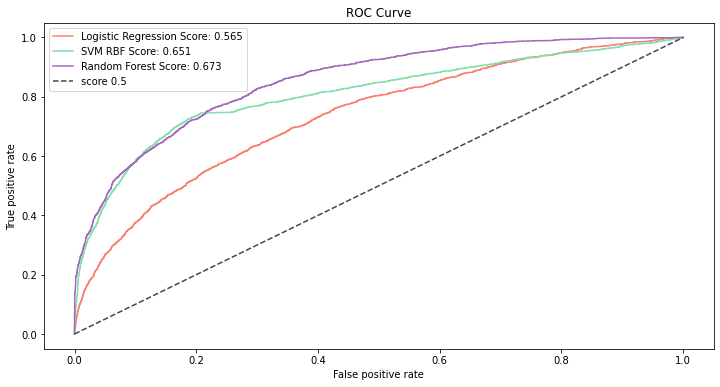

In [90]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log, tpr_log, label = f'Logistic Regression Score: {str(round(auc_log, 3))}', color='#FA8072')
plt.plot(fpr_svm, tpr_svm, label = f'SVM RBF Score: {str(round(auc_svm, 3))}', color='#82E0AA')
plt.plot(fpr_rf, tpr_rf, label = f'Random Forest Score: {str(round(auc_rf, 3))}', color='#A569BD')
plt.plot([0,1], [0,1], '--', label = 'score 0.5', color='#34495E')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Comparing the Area Under the Curve value for the three models, we see that the Random Forest performs better than the logistic regression model.

### 4. Feature Importance

We are going to analyze how the different features affect customer churn. For that, we are going to check the variable importance. That is to quantify how useful every variable is for our model.  

This is an important analysis. We can identify what are the features that make a customer more likely to churn and plan targeted strategies.  

For SVM is not possible to get the feature importance. As the algorithm works like a black box. For Logistic Regression, we can use the function SelectFromModelfrom sklearn.feature_selection. This function will select the features based on importance weights.

In [91]:
def get_most_important_features(model, num_features, model_type):
    selector = SelectFromModel(model, threshold=-np.inf, max_features=num_features)
    selector.fit(X_train, y_train)
    if model_type == "logistic":
        features_idx = selector.get_support()
        features_name = features[features_idx]
    else:
        return "It is not possible to get attributes"
    return features_name

#### Logistic Regression

In [92]:
get_most_important_features(model=best_log_estimator, num_features=4, model_type="logistic")

Index(['gender', 'number_products', 'is_active_member',
       'creditscore_age_ratio'],
      dtype='object')

We can see that gender, number of products, member status, and the credit score by age ratio are the four most important features to predict if a customer will churn.  

On the other hand, getting the feature importance from RandomForest is easy. The scikit-learn implementation has the method .feature_importances_ which will inform us of the importance of each feature.

#### Random Forest

In [93]:
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    #Get the list of feaature importance from the model
    importances = list(model.feature_importances_)
    #zip together feature names and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    #sort the feature importance by importance
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    #Print the list of feature importance
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    #set colors for the plot
    colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))
    
    #get the list of features sorted
    characteristics = [x[0] for x in feature_importances]
    #get the list of importance sorted
    importances_plot = [x[1] for x in feature_importances]
    #plot in a bar plot
    plt.bar(characteristics, importances_plot, color=colors)
    #adjust characteristics of the plot
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

Variable: number_products Importance: 0.45
Variable: creditscore_age_ratio Importance: 0.31
Variable: is_active_member Importance: 0.11
Variable: balance_salary_ratio Importance: 0.06
Variable: country Importance: 0.04
Variable: tenure Importance: 0.02
Variable: gender Importance: 0.01
Variable: owns_credit_card Importance: 0.0


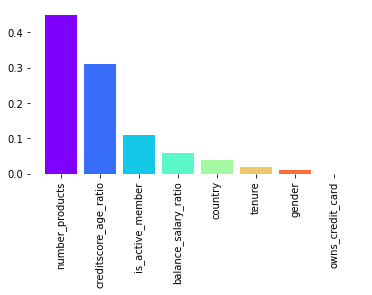

In [94]:
feature_importance(best_rf_estimator, features)

We can see thatnumber of products, member status, and the credit score by age ratio are again the most important features to predict if a customer will churn. Also, the balance salario ratio is important in this case.